In [140]:
# utilities
import pandas as pd 
import numpy as np
import datetime
from datetime import datetime as dt
from pandas import DataFrame
import warnings
warnings.filterwarnings('ignore')

# plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns

# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#model
from statsmodels.tsa.seasonal import seasonal_decompose #for the decomposition
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

Importing datasets

In [4]:
co2 = pd.read_csv('co2.csv')

no_raindays = pd.read_csv('rainfall-monthly-number-of-rain-days.csv')
no_raindays.rename(columns={'month':'Date'},inplace=True)

sea_level = pd.read_csv('sea_level.csv')
sea_level.rename(columns = {'Time':'Date'},inplace=True)

humidity = pd.read_csv('relative-humidity-monthly-mean.csv')
humidity.rename(columns = {'month':'Date'},inplace=True)

rainfall = pd.read_csv('rainfall-monthly-total.csv')
rainfall.rename(columns = {'month':'Date'},inplace=True)

temperature = pd.read_csv('surface-air-temperature-monthly-mean.csv')
temperature.rename(columns = {'month':'Date'},inplace=True)

anomaly_temperature = pd.read_csv('anomalies_temperature.csv')

Append new data to: co2, sea_level,anomaly_temperature in order to have data until the 2021.

First thing is to create a new list of dates then create the values of the measurement according to the values in the dataframe.

Change datatype of the column with the date into the datetime format 'YYYY-mm'

In [5]:
co2['Date'] = pd.to_datetime(co2['Date'], format = '%Y-%m')
co2['Date'] = co2['Date'].dt.strftime('%Y-%m')

sea_level['Date'] = pd.to_datetime(sea_level['Date'], format = '%Y-%m')
sea_level['Date'] = sea_level['Date'].dt.strftime('%Y-%m')

humidity['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
humidity['Date'] = humidity['Date'].dt.strftime('%Y-%m')

rainfall['Date'] = pd.to_datetime(humidity['Date'], format = '%Y-%m')
rainfall['Date'] = rainfall['Date'].dt.strftime('%Y-%m')

temperature['Date'] = pd.to_datetime(temperature['Date'], format = '%Y-%m')
temperature['Date'] = temperature['Date'].dt.strftime('%Y-%m')

anomaly_temperature['Date'] = pd.to_datetime(anomaly_temperature['Date'], format = '%Y-%m')
anomaly_temperature['Date'] = anomaly_temperature['Date'].dt.strftime('%Y-%m')

Now that the dataframes are modified and the cols have the same name and format, i can merge them on the Date and build a unique dataframe.

In [6]:
climate_change = no_raindays.merge(rainfall,on='Date').merge(humidity,on='Date').merge(temperature,on='Date').merge(co2,on='Date').merge(sea_level,on='Date').merge(anomaly_temperature,on='Date')
climate_change.tail()

,Date,no_of_rainy_days,total_rainfall,relative_humidity,surface_temp,co2,GMSL(Global Mean Sea Level),Anomalies_Land_Ocean_Temperature
473,2021-06,20,93.4,77.8,28.5,427.2,13.5,2.59
474,2021-07,12,195.8,76.5,28.6,428.0,13.5,2.62
475,2021-08,24,293.6,80.4,27.6,428.8,13.6,2.65
476,2021-09,14,205.4,77.3,28.3,429.6,13.6,2.68
477,2021-10,14,177.0,78.3,28.5,430.4,13.7,2.71


In [7]:
# change the column values from percentage to decimal 
climate_change['relative_humidity'] = climate_change['relative_humidity'].apply(lambda x: x / 100)
#save the dataframe to csv
climate_change.to_csv('climate_change.csv',index=False)

In [10]:
#check there are no missing values
climate_change.isna().sum()

Date                                0
no_of_rainy_days                    0
total_rainfall                      0
relative_humidity                   0
surface_temp                        0
co2                                 0
GMSL(Global Mean Sea Level)         0
Anomalies_Land_Ocean_Temperature    0
dtype: int64

DATA VISUALIZATION

In [11]:
def correlation(data : pd.core.frame.DataFrame):
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix) #to plot only a half matrix
    mask[np.triu_indices_from(mask)] = True #to generate a mask for the upper triangle
    sns.heatmap(corr_matrix, mask=mask, square=True,cmap="PuOr_r")
    return

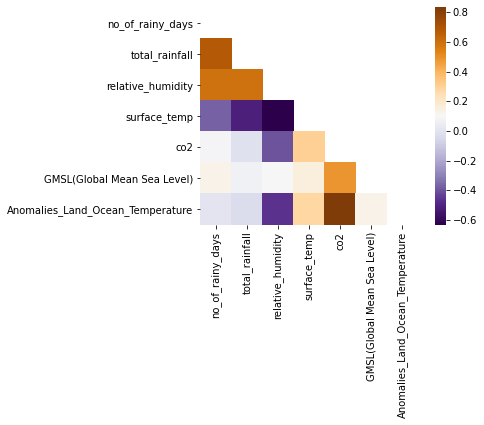

In [12]:
correlation(climate_change)

In [ ]:
values = ['co2','no_of_rainy_days','GMSL(Global Mean Sea Level)','relative_humidity','total_rainfall',
            'surface_temp','Anomalies_Land_Ocean_Temperature']

Autocorrelation

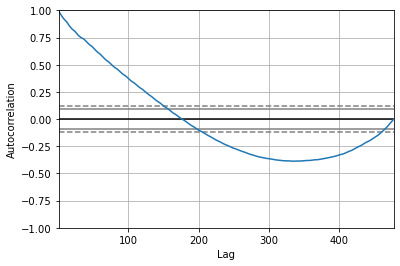

In [18]:
pd.plotting.autocorrelation_plot(climate_change['co2'])
plt.show()
# from this plot we can see that there is a positive correlation with the first 100-to-180 lags that is perhaps 
# significant for the the first 150 lags.

# Hence a good starting point for the AR parametere for co2 could be 100.

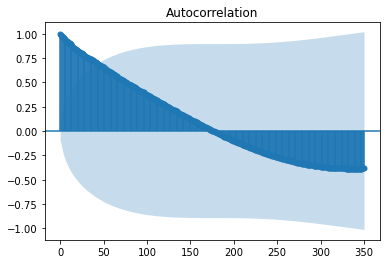

In [14]:
plot_acf(climate_change['co2'], lags=350)
plt.show()

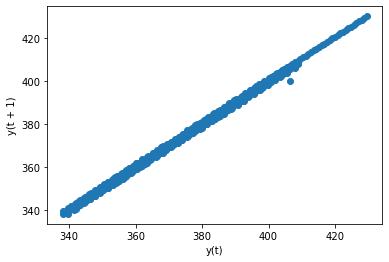

In [15]:
pd.plotting.lag_plot(climate_change['co2'])
plt.show()

Partial autocorrelation

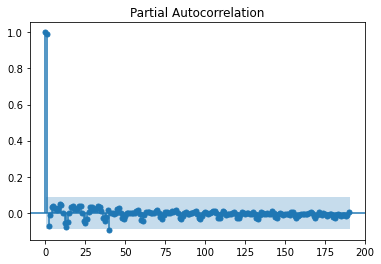

In [16]:
plot_pacf(climate_change['co2'], lags=190)
plt.show()

**ARIMA** stands for:

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations;

- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationar;

- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations;

A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.

- d: The number of times that the raw observations are differenced, also called the degree of differencing.

- q: The size of the moving average window, also called the order of moving average.


Time series decomposition - do it for all the variables - 

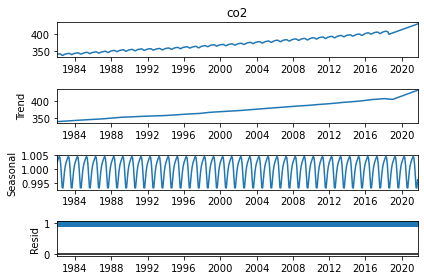

In [37]:
# Multiplicative Decomposition 
climate_change['co2'].index = pd.to_datetime(climate_change['co2'].index) 
decomp_mul = seasonal_decompose(climate_change['co2'], model='multiplicative', extrapolate_trend='freq', period=12)
decomp_mul.plot()
plt.show()

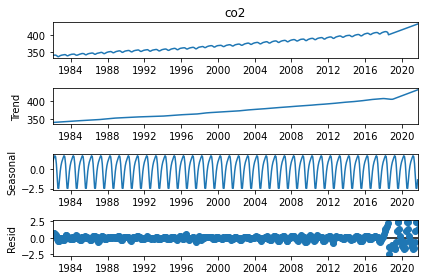

In [38]:
# Additive Decomposition
decomp_add = seasonal_decompose(climate_change['co2'], model='additive', extrapolate_trend='freq', period=12)
decomp_add.plot()
plt.show()

Split into train-test and perform forecasting for the co2 data

C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Stefania\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


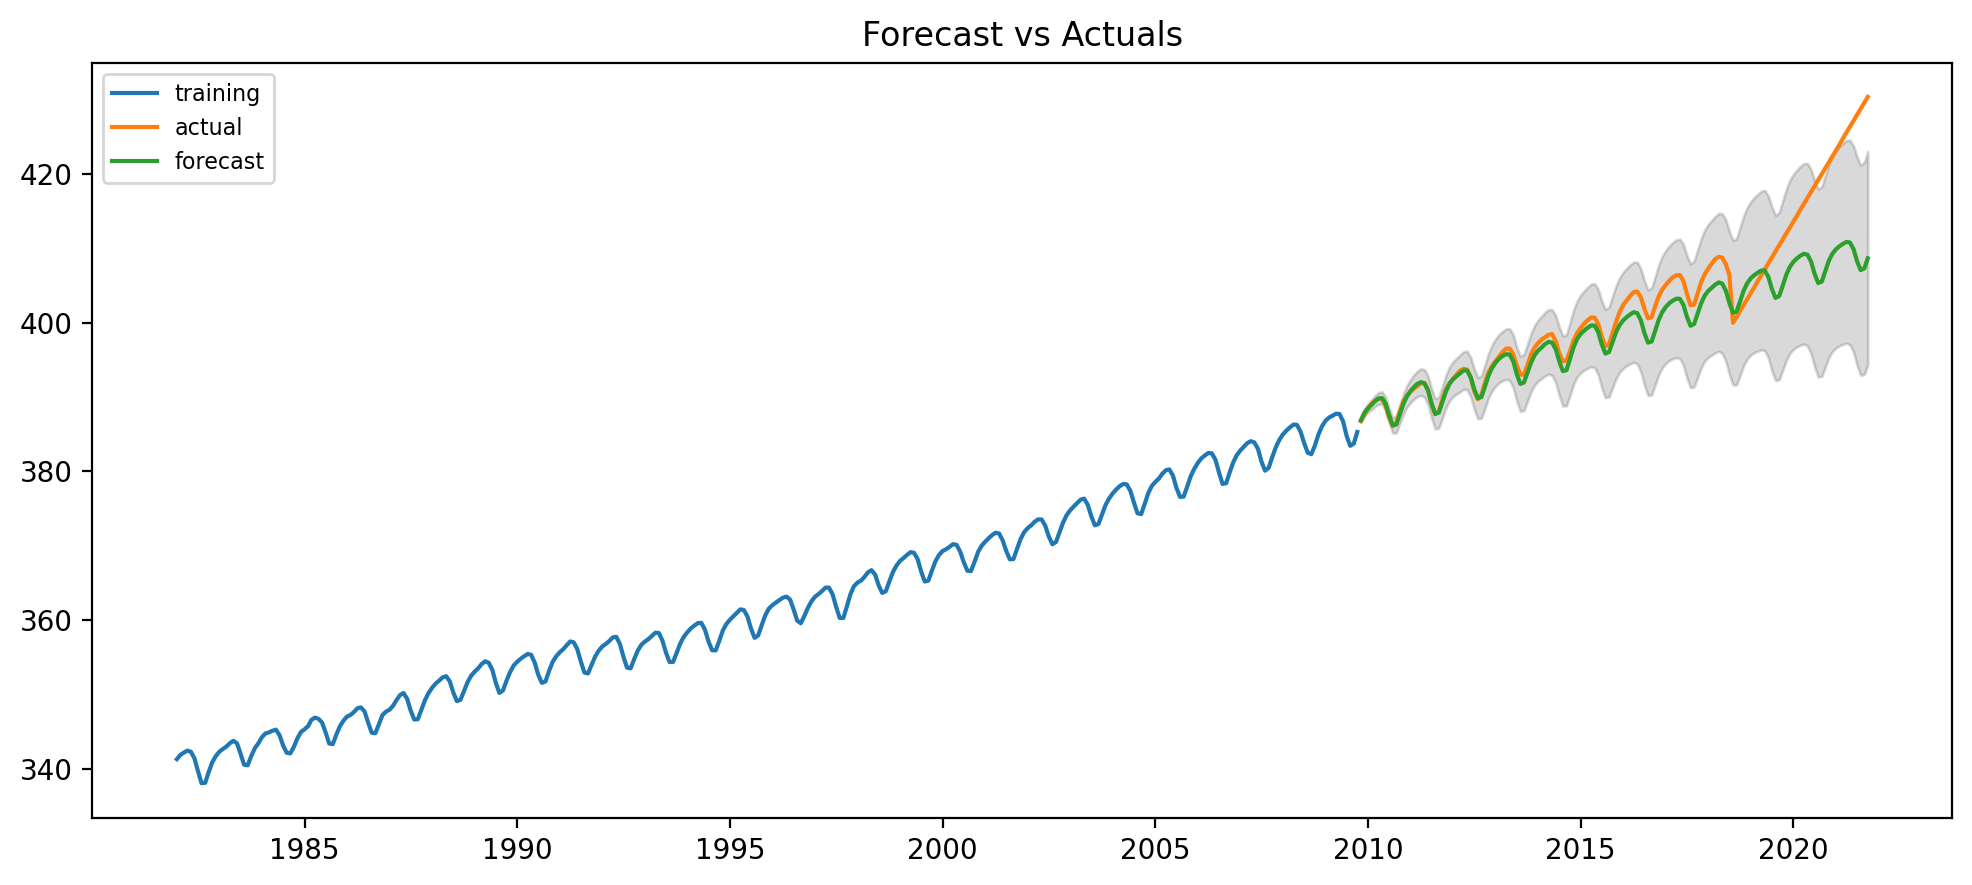

In [41]:
train = climate_change['co2'][:int(np.floor((len(climate_change)/100)*70))] #70% train
test = climate_change['co2'][int(np.floor((len(climate_change)/100)*70)):] #30% train

model = ARIMA(train, order=(80, 2, 1))  
fitted = model.fit()  

fc = fitted.get_forecast(len(climate_change['co2'][int(np.floor((len(climate_change)/100)*70)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## VARIMA (Vector Arima for multivariate time series forecasting)

Steps:

 1) Causality investigation
 2) Test for stationary
 3) Model 
 4) Prediction
 4) Evaluation


In [54]:
''' 1. CAUSALITY INVESTIGATION 
The Granger Causality Test is used to investigate causality of data: check if a particular variable comes before 
another in the time series.
The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y
(so the x does not cause y).
The critical value used is 5% and if the p-value of a pair of variables is smaller than 0.05, 
then it can be assumed that with 95% confidence a predictor x causes a response y.
'''
from statsmodels.tsa.stattools import grangercausalitytests

variables=climate_change.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(climate_change[[row, col]], maxlag=30, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(30)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]
pd.DataFrame(matrix)

,no_of_rainy_days_x,total_rainfall_x,relative_humidity_x,surface_temp_x,co2_x,GMSL(Global Mean Sea Level)_x,Anomalies_Land_Ocean_Temperature_x
no_of_rainy_days_y,1.0000,0.0022,0.0000,0.000,0.0000,0.0051,0.0002
total_rainfall_y,0.0000,1.0000,0.0000,0.000,0.0000,0.1896,0.1522
relative_humidity_y,0.0000,0.0000,1.0000,0.000,0.0000,0.3026,0.0000
surface_temp_y,0.0000,0.0000,0.0000,1.000,0.0000,0.2700,0.0000
co2_y,0.0000,0.0000,0.0000,0.000,1.0000,0.0544,0.0000
GMSL(Global Mean Sea Level)_y,0.0227,0.0179,0.0031,0.075,0.3634,1.0000,0.0566
Anomalies_Land_Ocean_Temperature_y,0.0014,0.0066,0.0007,0.000,0.0007,0.0134,1.0000


Let's analyze the result obtained. For most of the variables, since the p-values are < 0.05, i can reject the null hypothesis and use them for the VARIMA model. 

But for some variables i can't reject the null hypothesis, in fact the p-values for:
- (GMSL_x,total_rainfall_y) - (GMSL_x,relative_humidity_y) - (GMSL_x,surface_temp_y) - (GMSL_x, co2_y)

- (Anomalies_Land_Ocean_Temperature_x,total_rainfall_y)

are bigger than 0.05. That means that the **GMSL doesn't cause the total rainfall, the relative humidity, the surface temperature and the co2** neither, as well as the **Anomalies_Land_Ocean_Temperature doesn't cause the total rainfall**. 

*As it can be notice, this analysis makes sense since - for example - it's reasonable that the total rainfall causes the surface temperature, the humidity and the anomalies in the temperature; just as it would have made less sense if the co2 emissions causes the Global Mean Sea Level - but for sure it causes the surface temperature.*

In the end i can state that, exept for the GMSL and the pair (Anomalies_Land_Ocean_Temperature_x,total_rainfall_y), the other variables are interchangeably causing each other. 

For now on i will not include the GMSL in the model.

In [74]:
#CLIMATE DATA WITHOUT GMSL
data_cc = climate_change.drop(['GMSL(Global Mean Sea Level)'],axis=1)

In [75]:
''' 2. STATIONARITY TEST
VectorARIMA requires time series to be stationary, and for this test i use the ADF Test.
'''

from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary")

for name, column in data_cc.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary. 
 total_rainfall : P-Value = 0.0 => Stationary. 
 relative_humidity : P-Value = 0.233 => Non-stationary.
 surface_temp : P-Value = 0.0 => Stationary. 
 co2 : P-Value = 0.999 => Non-stationary.
 Anomalies_Land_Ocean_Temperature : P-Value = 0.999 => Non-stationary.


In [76]:
'''
Since for the relative_humidity,co2 and Anomalies_Land_Ocean_Temperature the test fails, 
i need to make the data stationary (eliminating the trend and seasonality by differencing (first and second if needed) and seasonal decomposition)
'''
data_differenced = data_cc.diff().dropna()
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)


 no_of_rainy_days : P-Value = 0.0 => Stationary. 
 total_rainfall : P-Value = 0.0 => Stationary. 
 relative_humidity : P-Value = 0.0 => Stationary. 
 surface_temp : P-Value = 0.0 => Stationary. 
 co2 : P-Value = 0.023 => Stationary. 
 Anomalies_Land_Ocean_Temperature : P-Value = 0.0 => Stationary. 


So after differenciating i made all the data stationary and also since degree of differencing is **1** it could be used as value of **d** in the model building.

To find the optimal values for the p and q i will perform a grid search and pick the best value according to the AIC.

-------------------------------------------------------------------------------------------------

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/


In [138]:
'''' Train-test splitting'''
train = climate_change[:int(np.floor((len(climate_change)/100)*70))] #70% train
test = climate_change[int(np.floor((len(climate_change)/100)*70)):] #30% train

In [141]:
for i in [5,6,7,8,9,10,11,12,13,14,15]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print()

Order = 5
AIC:  -5.661828467307256

Order = 6
AIC:  -5.74780371479101

Order = 7
AIC:  -5.927044083384472

Order = 8
AIC:  -5.90271527637459

Order = 9
AIC:  -6.071265831003814

Order = 10
AIC:  -6.138234858624451

Order = 11
AIC:  -6.037242587310795

Order = 12
AIC:  -6.04413052060665

Order = 13
AIC:  -6.150376563434058

Order = 14
AIC:  -6.038155497433709

Order = 15
AIC:  -5.944050824646661



As the value of the P increases model becomes more complex and the AIC penalizes the complex model.

As can be seen from the result, the AIC begins to drop as i fit the more complex model (around 10) but, after a certain amount of time AIC begins to increase again (from 11). It’s because AIC is punishing these models for being too complex.

The VAR(p=10) returns the lowest score and after that again AIC starts increasing, hence i will build the VAR model of order 10. 

In [101]:
result = model.fit(10)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Dec, 2021
Time:                     17:55:31
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                  -0.338761
Nobs:                     324.000    HQIC:                  -3.82340
Log likelihood:          -1726.76    FPE:                 0.00227071
AIC:                     -6.13823    Det(Omega_mle):     0.000567280
--------------------------------------------------------------------
Results for equation no_of_rainy_days
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                      -53.905622        62.800966           -0.858           0.391
L1.no_of_rainy_days                         -0.002104        

PREDICTION

In [126]:
lag = result.k_ar #10
lagged_Values = train.values[-lag:] # specify the 'initial value' for the forecast
pred = result.forecast(y=lagged_Values, steps=12) 

idx = pd.date_range('2021-01-01', periods=12, freq='MS')
cols = ['no_of_rainy_days_P','total_rainfall_P','relative_humidity_P','surface_temp_P','co2_P','GMSL(Global Mean Sea Level)_P','Anomalies_Land_Ocean_Temperature_P']
df_forecast=pd.DataFrame(data=pred, index=idx, columns=cols)

INVERT THE TRANSFORMATION

Notice that the forecasted value is a first-order difference. To get it similar to original data i have to 'roll back' each difference by taking the most recent values of the original series’ training data and adding it to a cumulative sum of forecasted values.


In [127]:
test_obs = 144 #no of observations in the test data

df_forecast['Rainy_days_F'] = data_cc['no_of_rainy_days'].iloc[-test_obs-1] + df_forecast['no_of_rainy_days_P'].cumsum()

df_forecast['total_rainfall_F'] = data_cc['total_rainfall'].iloc[-test_obs-1] + df_forecast['total_rainfall_P'].cumsum()

df_forecast['relative_humidity_F'] = data_cc['relative_humidity'].iloc[-test_obs-1] + df_forecast['relative_humidity_P'].cumsum()

df_forecast['surface_temp_F'] = data_cc['surface_temp'].iloc[-test_obs-1] + df_forecast['surface_temp_P'].cumsum()

df_forecast['co2_F'] = data_cc['co2'].iloc[-test_obs-1] + df_forecast['co2_P'].cumsum()

df_forecast['Anomalies_Land_Ocean_Temperature_F'] = data_cc['Anomalies_Land_Ocean_Temperature'].iloc[-test_obs-1] + df_forecast['Anomalies_Land_Ocean_Temperature_P'].cumsum()


Plot the result

<AxesSubplot:xlabel='Date'>

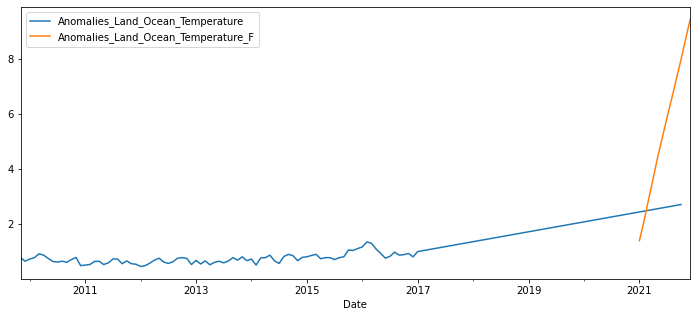

In [133]:
test_original = data_cc[-test_obs:]
test_original.index = pd.to_datetime(test_original.index)

test_original['Anomalies_Land_Ocean_Temperature'].plot(figsize=(12,5),legend=True)
df_forecast['Anomalies_Land_Ocean_Temperature_F'].plot(legend=True)